In [1]:
import os

# 1️⃣ MUST set before importing zarr!
os.environ["ZARR_V3_EXPERIMENTAL_API"] = "1"

import zarr
import xarray as xr
from numcodecs import Blosc

# 2️⃣ Open dataset
ds = xr.open_dataset("GEBCO_2025_land_mask.nc")

# 3️⃣ Chunk and shard sizes
chunk_shape = (4320, 8640)
shard_shape = (1000, 1000)

# 4️⃣ Compressor
compressor = Blosc(cname="zstd", clevel=3, shuffle=Blosc.SHUFFLE)

# 5️⃣ Create Zarr v3 root group using DirectoryStore
store = zarr.DirectoryStore("GEBCO_2025_land_mask_sharded.zarr")

# 6️⃣ Use Zarr v3 experimental Group API
root = zarr.group(store=store, overwrite=True)

# 7️⃣ Write each variable as a sharded array and add _ARRAY_DIMENSIONS
for var in ds.data_vars:
    data = ds[var].data
    shape = data.shape
    dtype = data.dtype

    arr = root.create(
        name=var,
        shape=shape,
        dtype=dtype,
        chunks=chunk_shape,
        compressor=compressor,
        # shards=shard_shape  # uncomment if your Zarr version supports it
    )

    arr[:] = data

    # Add xarray-compatible dimensions
    arr.attrs["_ARRAY_DIMENSIONS"] = list(ds[var].dims)

# 8️⃣ Optionally, add coordinate variables
for coord in ds.coords:
    data = ds[coord].data
    shape = data.shape
    dtype = data.dtype

    arr = root.create(
        name=coord,
        shape=shape,
        dtype=dtype,
        chunks=data.shape,
        compressor=compressor
    )
    arr[:] = data
    arr.attrs["_ARRAY_DIMENSIONS"] = list(ds[coord].dims)

# 9️⃣ Copy global attributes
root.attrs.update(ds.attrs)

zarr.consolidate_metadata(store)

print("✅ Dataset written to Zarr v3 with manual _ARRAY_DIMENSIONS for xarray")

✅ Dataset written to Zarr v3 with manual _ARRAY_DIMENSIONS for xarray


In [2]:
ds = xr.open_dataset("GEBCO_2025_land_mask_sharded.zarr")

In [5]:
ds

<xarray.Dataset> Size: 15GB
Dimensions:  (lat: 43200, lon: 86400)
Coordinates:
  * lat      (lat) float64 346kB -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 90.0
  * lon      (lon) float64 691kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    lsm      (lat, lon) float32 15GB ...

In [ ]:
import os
#os.environ["ZARR_V3_EXPERIMENTAL_API"] = "1"

import zarr 
import xarray as xr

ds = xr.open_dataset("GEBCO_2025_land_mask.nc")

ds = ds.chunk(lat = 4320, lon = 8640)

ds

import zarr
from zarr.codecs import Blosc

encoding = {
    var: {
        "chunks": (4320, 8640),
        #"shards": (4000, 4000),
        "compressor": Blosc(
            cname="zstd",
            clevel=3,
            shuffle=Blosc.SHUFFLE,
        ),
    }
    for var in ds.data_vars
}

ds.to_zarr(
    "GEBCO_2025_land_mask.zarr",
    mode="w",
    encoding=encoding,
    consolidated = True
)

In [7]:
fs.ls('')

NameError: name 'fs' is not defined

In [1]:
import zarr 
import xarray as xr
ds = xr.open_zarr("GEBCO_2025_land_mask_big_chunk.zarr")

In [2]:
ds

<xarray.Dataset> Size: 15GB
Dimensions:  (lat: 43200, lon: 86400)
Coordinates:
  * lat      (lat) float64 346kB -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 90.0
  * lon      (lon) float64 691kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    lsm      (lat, lon) float32 15GB dask.array<chunksize=(1000, 1000), meta=np.ndarray>

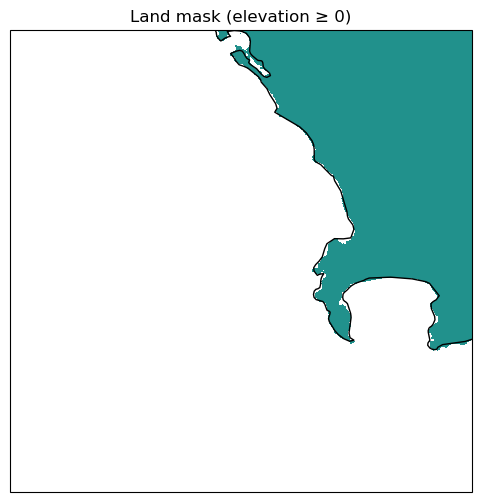

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# --- configuration ---
lat0, lon0 = -34, 18      # central point
dlat, dlon = 1.0, 1.0     # half-width of bounding box

# --- subset ---
land_binary = ds.sel(
    lat=slice(lat0 - dlat, lat0 + dlat),
    lon=slice(lon0 - dlon, lon0 + dlon),
).lsm


# --- plot ---
proj = ccrs.PlateCarree()

fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw={"projection": proj},
)

land_binary.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
)

ax.coastlines()
ax.set_extent(
    [lon0 - dlon, lon0 + dlon, lat0 - dlat, lat0 + dlat],
    crs=ccrs.PlateCarree(),
)

ax.set_title("Land mask (elevation ≥ 0)")

plt.show()
